Credit: [Baseline Code](https://github.com/bentrevett/pytorch-rl/blob/master/5a%20-%20Proximal%20Policy%20Optimization%20(PPO)%20%5BLunarLander%5D.ipynb) For PPO implementation on LunarLander V2

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from typing import Tuple

In [19]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)

In [20]:
train_env = gym.make("LunarLander-v3", render_mode="rgb_array")
test_env = gym.make("LunarLander-v3", render_mode="rgb_array")

In [21]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, dropout: float = 0.1):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.net(x)
        return x

In [35]:
class ActorCritic(nn.Module):
    def __init__(self, device, actor: nn.Module, critic: nn.Module):
        super().__init__()
        
        self.device = device
        self.actor = actor.to(self.device)
        self.critic = critic.to(self.device)
        
    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        
        state = state.to(self.device)
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(device, actor, critic)

In [37]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (critic): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [43]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns).to(device)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

def calculate_advantages(returns, values, normalize = True):
    
    advantages = returns - values
    
    if normalize:
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

def update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip):
    
    total_policy_loss = 0 
    total_value_loss = 0
    
    states = states.detach()
    actions = actions.detach()
    log_prob_actions = log_prob_actions.detach()
    advantages = advantages.detach()
    returns = returns.detach()
    
    for _ in range(ppo_steps):
                
        #get new log prob of actions for all input states
        action_pred, value_pred = policy(states)
        value_pred = value_pred.squeeze(-1)
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)
        
        #new log prob using old actions
        new_log_prob_actions = dist.log_prob(actions)
        
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
                
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages
        
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).mean()
        
        value_loss = F.smooth_l1_loss(returns, value_pred).mean()
    
        optimizer.zero_grad()

        policy_loss.backward()
        value_loss.backward()

        optimizer.step()
    
        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()
    
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

In [44]:
def train(env, policy, optimizer, discount_factor, ppo_steps, ppo_clip):
        
    policy.train()
        
    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []
    term = False
    trunc = False
    episode_reward = 0

    state, info = env.reset(seed=seed)

    while not term and not trunc:

        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        #append state here, not after we get the next state from env.step()
        states.append(state)
        
        action_pred, value_pred = policy(state)
                
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)
        
        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)

        state, reward, term, trunc, _ = env.step(action.item())

        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        
        episode_reward += reward
    
    states = torch.cat(states)
    actions = torch.cat(actions)    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip)

    return policy_loss, value_loss, episode_reward

In [45]:
def evaluate(env, policy):
    
    policy.eval()
    
    rewards = []
    term = False
    trunc = False
    episode_reward = 0

    state, info = env.reset(seed=seed)

    while not term and not trunc:

        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        with torch.no_grad():
        
            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)
                
        action = torch.argmax(action_prob, dim = -1)
                
        state, reward, term, trunc, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward

In [46]:
MAX_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 200
PRINT_EVERY = 10
PPO_STEPS = 5
PPO_CLIP = 0.2
LEARNING_RATE = 0.0005

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

train_rewards = []
test_rewards = []

In [47]:
for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(test_env, policy)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
        
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

| Episode:  10 | Mean Train Rewards:  -190.1 | Mean Test Rewards:  -223.9 |
| Episode:  20 | Mean Train Rewards:  -171.8 | Mean Test Rewards:  -233.3 |
| Episode:  30 | Mean Train Rewards:  -151.9 | Mean Test Rewards:  -248.6 |
| Episode:  40 | Mean Train Rewards:  -114.4 | Mean Test Rewards:  -210.7 |
| Episode:  50 | Mean Train Rewards:   -97.5 | Mean Test Rewards:  -200.5 |
| Episode:  60 | Mean Train Rewards:  -105.6 | Mean Test Rewards:  -348.6 |
| Episode:  70 | Mean Train Rewards:  -101.4 | Mean Test Rewards:  -774.5 |
| Episode:  80 | Mean Train Rewards:   -90.5 | Mean Test Rewards: -1166.4 |
| Episode:  90 | Mean Train Rewards:   -71.9 | Mean Test Rewards: -1309.6 |
| Episode: 100 | Mean Train Rewards:   -55.4 | Mean Test Rewards:  -693.9 |
| Episode: 110 | Mean Train Rewards:   -55.0 | Mean Test Rewards:  -482.1 |
| Episode: 120 | Mean Train Rewards:   -50.5 | Mean Test Rewards:  -507.4 |
| Episode: 130 | Mean Train Rewards:   -16.8 | Mean Test Rewards:  -431.3 |
| Episode: 1

### Visualize the reward history

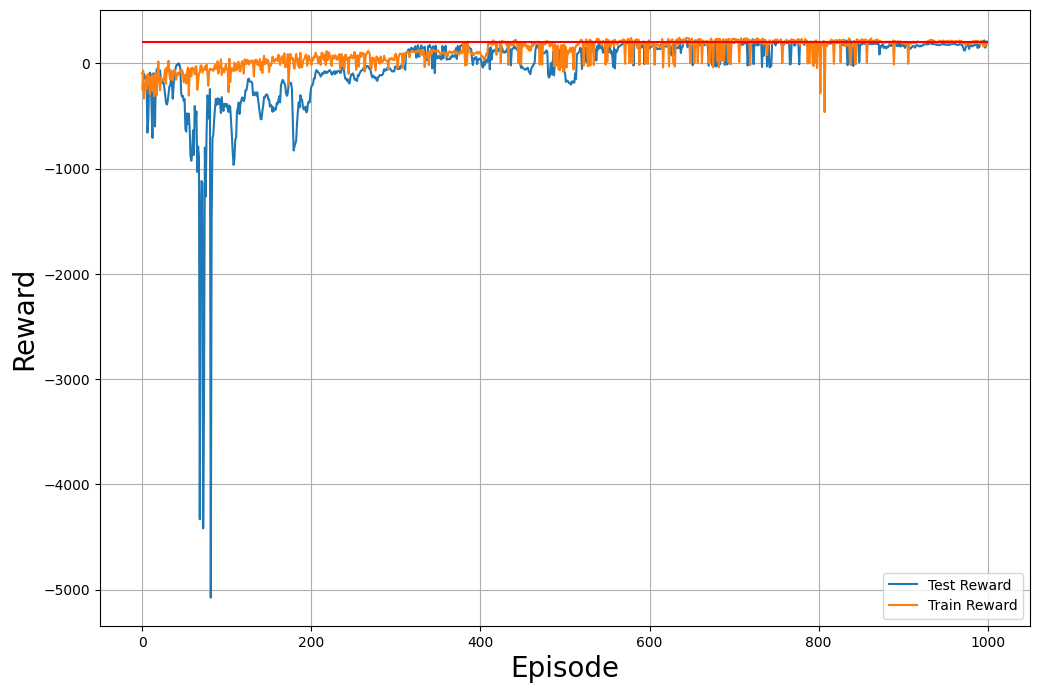

In [48]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()

### Test RL agent's Performance

KeyboardInterrupt: 

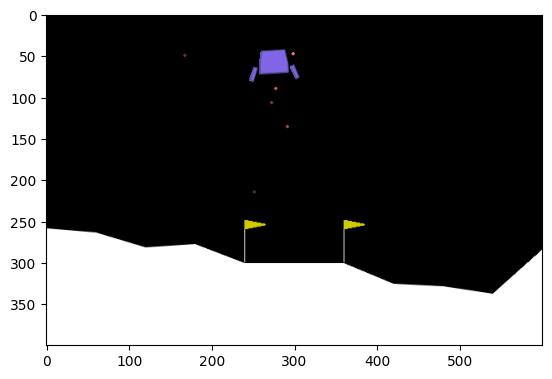

In [42]:
from IPython import display
plt.ion()

policy.eval()

term = False
trunc = False

env = gym.make("LunarLander-v3", render_mode="rgb_array")
state, info = env.reset(seed=seed)

while not term and not trunc:
  state = torch.FloatTensor(state).unsqueeze(0)
  with torch.no_grad():
    action_pred, _ = policy(state)
    action_prob = F.softmax(action_pred, dim = -1)
  action = torch.argmax(action_prob, dim = -1)
  state, reward, term, trunc, _ = env.step(action.item())

  plt.imshow(env.render())
  display.display(plt.gcf())
  display.clear_output(wait=True)

  if term or trunc:
    break

env.close()